In [3]:
import roboticstoolbox as rtb
import spatialmath as sm
from math import pi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def compute_angle_to_origin(transform_matrix):
    """
    Compute the angle needed to rotate the x-axis of a given transformation
    matrix so that it points towards the origin.

    Parameters:
    - transform_matrix: A 4x4 numpy array representing the homogeneous transformation matrix.

    Returns:
    - The angle in degrees that the x-axis of the transformed frame needs to be
      rotated by to point towards the origin.
    """
    # Extract the translation components (P_x, P_y) from the matrix
    P_x, P_y = transform_matrix[0, 3], transform_matrix[1, 3]
    
    # Calculate the angle between the vector pointing from the frame's current position
    # to the origin and the global x-axis. This uses atan2 and is adjusted by 180 degrees
    # to account for the direction towards the origin.
    angle_to_origin = np.degrees(np.arctan2(-P_y, -P_x))
    
    # Calculate the initial orientation of the frame's x-axis relative to the global x-axis.
    # This is the angle of rotation about the z-axis that has already been applied to the frame.
    # We use the elements of the rotation matrix to find this angle.
    R11, R21 = transform_matrix[0, 0], transform_matrix[1, 0]
    initial_orientation = np.degrees(np.arctan2(R21, R11))
    
    # Compute the additional rotation needed from the frame's current orientation.
    # This is the difference between the angle to the origin and the frame's initial orientation.
    additional_rotation = angle_to_origin - initial_orientation
    
    # Normalize the result to the range [-180, 180]
    additional_rotation = (additional_rotation + 180) % 360 - 180
    
    return additional_rotation


T1 = sm.SE3(4,0,0) * sm.SE3.Rz(30, 'deg') * sm.SE3.Ry(10, 'deg')

plt.figure()
sm.SE3().plot(frame='0', dims=[-5, 5], color='black')
T1.plot(frame='1', color='red')
plt.grid(True)
plt.show()


Angle to origin: 150.00 degrees


<Figure size 640x480 with 0 Axes>

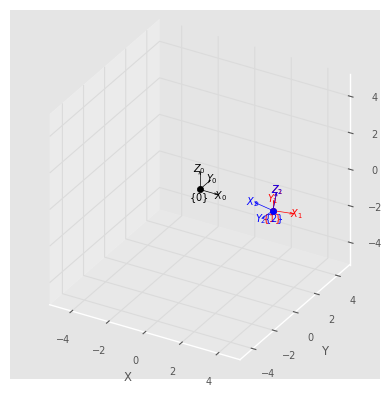

In [125]:
alpha = compute_angle_to_origin(np.array(T1))

print(f"Angle to origin: {alpha:.2f} degrees")

# create a new SE3 object that is a rotation of T1 about the Z-axis by theta
T2 = T1 * sm.SE3.Rz(np.deg2rad(alpha))

plt.figure()
sm.SE3().plot(frame='0', dims=[-5, 5], color='black')
T1.plot(frame='1', color='red')
T2.plot(frame='2', color='blue')
plt.grid(True)
plt.show()





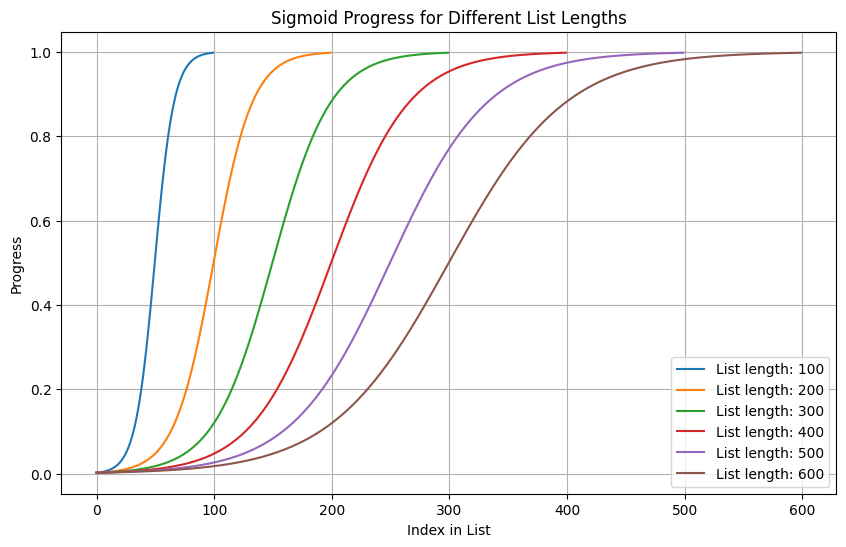

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid_progress(length):
    x = np.linspace(-6, 6, length)
    return 1 / (1 + np.exp(-x))

def plot_sigmoid_progress(list_lengths):
    plt.figure(figsize=(10, 6))
    for length in list_lengths:
        progress = sigmoid_progress(length)
        plt.plot(progress, label=f'List length: {length}')
    
    plt.title('Sigmoid Progress for Different List Lengths')
    plt.xlabel('Index in List')
    plt.ylabel('Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
list_lengths = [100, 200, 300, 400, 500, 600]
plot_sigmoid_progress(list_lengths)

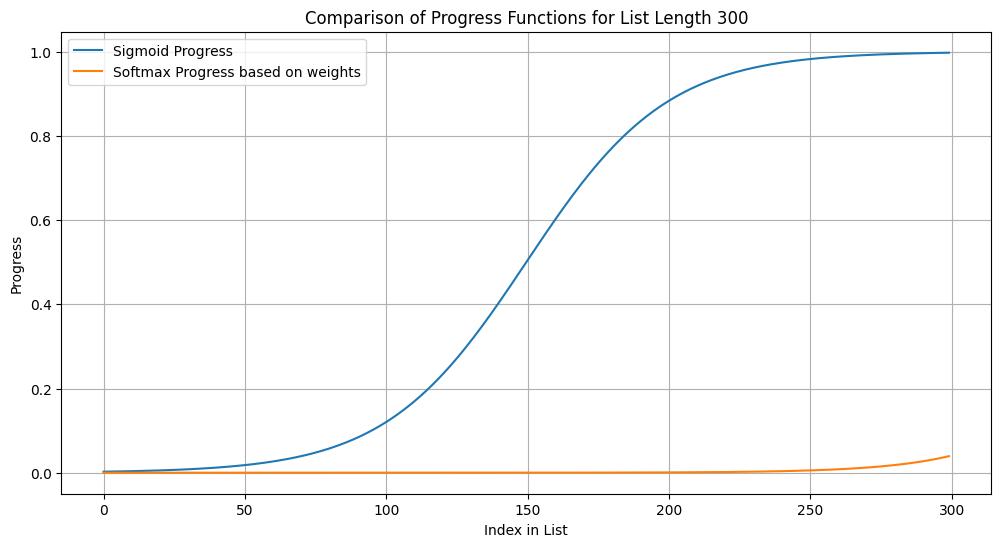

: 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def softmax_progress(weights):
    e_x = np.exp(weights - np.max(weights))  # Subtract max for numerical stability
    return e_x / e_x.sum()

def plot_progress_comparison(list_length):
    # Sigmoid
    sigmoid_values = sigmoid_progress(list_length)

    # Softmax - here using the same linspace values as "weights" for simplicity
    weights = np.linspace(-6, 6, list_length)
    softmax_values = softmax_progress(weights)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmoid_values, label='Sigmoid Progress')
    plt.plot(softmax_values, label='Softmax Progress based on weights')
    plt.title(f'Comparison of Progress Functions for List Length {list_length}')
    plt.xlabel('Index in List')
    plt.ylabel('Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_progress_comparison(300)


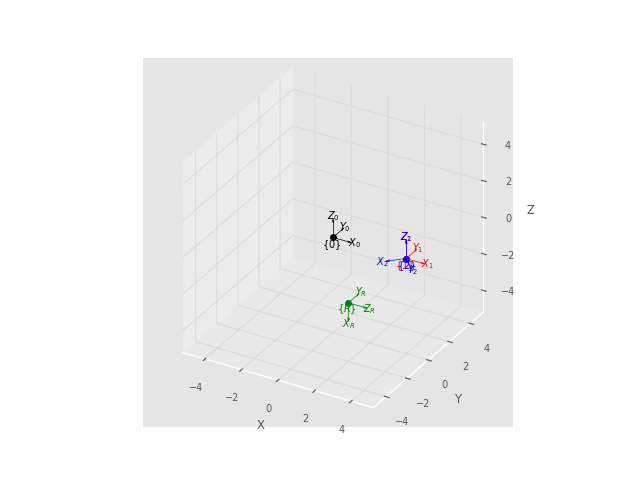

Resulting Frame:
  -0.7071    0.7071    0         4         
  -0.7071   -0.7071    0         0         
   0         0         1         0         
   0         0         0         1         



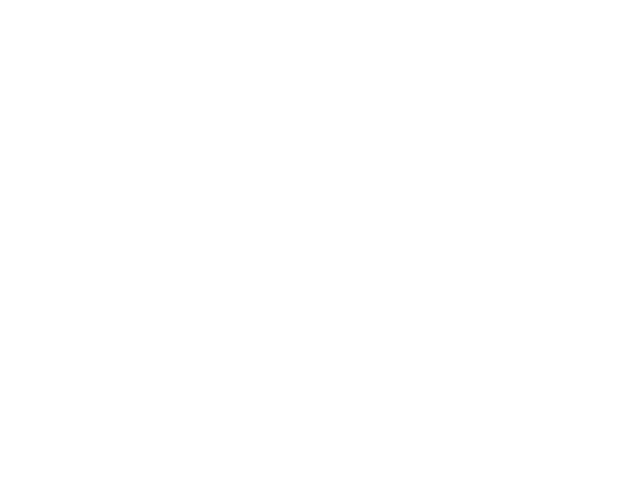

In [62]:
import roboticstoolbox as rtb
import spatialmath as sm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def compute_oriented_affordance_frame(self, transform_matrix, base_frame=np.eye(4)):
    """
    Compute the angle needed to rotate the x-axis of a given transformation
    matrix so that it points towards the base frame. Apply the rotation to the
    transformation matrix and return the resulting matrix.

    Parameters:
    - transform_matrix: A 4x4 numpy array representing the homogeneous transformation matrix.
    - base_frame: A 4x4 numpy array representing the base frame (default is the identity matrix).

    Returns:
    - The transformation matrix with the x-axis pointing towards the base frame.
    """
    # Convert inputs to numpy arrays if they are not already
    transform_matrix = np.array(transform_matrix)
    base_frame = np.array(base_frame)

    # Calculate the position of the base frame in global coordinates
    ref_position_global = base_frame[:3, 3]
    
    # Extract the position of the transform matrix (T1) in global coordinates
    position_global = transform_matrix[:3, 3]
    
    # Calculate the direction vector from T1 to the base frame
    direction_vector = ref_position_global - position_global
    
    # Calculate the angle between the x-axis of T1 and the direction vector
    angle_to_reference = np.degrees(np.arctan2(direction_vector[1], direction_vector[0]))
    
    # Extract the current orientation of the x-axis of T1
    R11, R21 = transform_matrix[0, 0], transform_matrix[1, 0]
    current_orientation = np.degrees(np.arctan2(R21, R11))
    
    # Calculate the additional rotation needed to align the x-axis with the direction vector
    additional_rotation = angle_to_reference - current_orientation
    
    # Normalize the result to the range [-180, 180]
    additional_rotation = (additional_rotation + 180) % 360 - 180
    
    # Apply the additional rotation to T1 about the z-axis
    resulting_frame = sm.SE3(transform_matrix) * sm.SE3.Rz(np.deg2rad(additional_rotation))
    
    return resulting_frame

# Example usage
# Define the initial transformation matrix T1
T1 = sm.SE3(4, 0, 0) #* sm.SE3.Rz(30, 'deg') * sm.SE3.Ry(10, 'deg')

# Define the base frame rotated about the y-axis such that the z-axis points downwards
base_frame = sm.SE3(2, -2, -2) * sm.SE3.Ry(90, 'deg')

# Compute the oriented affordance frame
resulting_frame = compute_oriented_affordance_frame(None, T1, base_frame)

# Visualize the initial, base, and resulting frames
plt.figure()
sm.SE3().plot(frame='0', dims=[-5, 5], color='black')
base_frame.plot(frame='R', color='green')
T1.plot(frame='1', color='red')
resulting_frame.plot(frame='2', color='blue')
plt.grid(True)
plt.show()

print(f"Resulting Frame:\n{resulting_frame}")


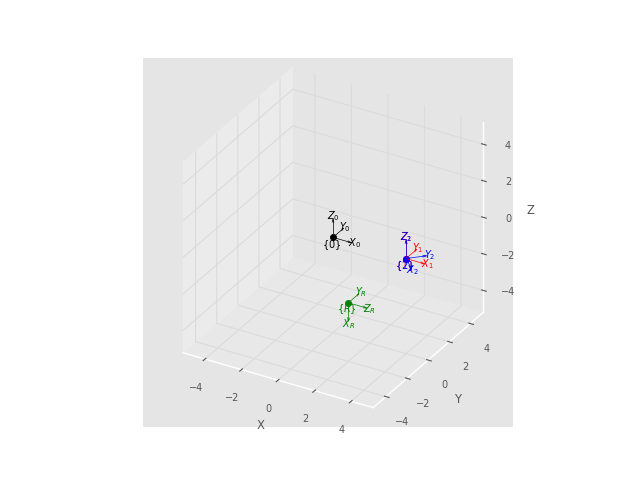

Resulting Frame:
   0.7071    0.7071    0         4         
  -0.7071    0.7071    0         0         
   0         0         1         0         
   0         0         0         1         



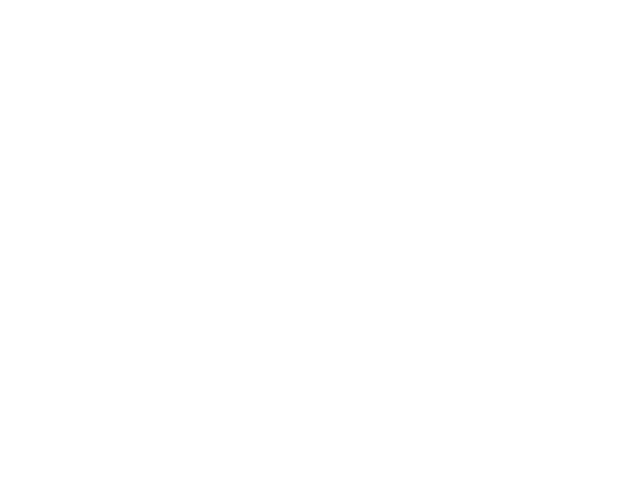

In [61]:
def compute_oriented_affordance_frame(self, transform_matrix, base_frame=np.eye(4)):
        """
        Compute the angle needed to rotate the x-axis of a given transformation
        matrix so that it points towards the base frame. Apply the rotation to the
        transformation matrix and return the resulting matrix.

        Parameters:
        - transform_matrix: A 4x4 numpy array representing the homogeneous transformation matrix.

        Returns:
        - The transformation matrix with the x-axis pointing towards the base frame.
        """

        # if the base frame is not the origin, we need to transform the matrix to the base frame
        if not np.array_equal(base_frame, np.eye(4)):
            transform_matrix = np.dot(np.linalg.inv(base_frame), transform_matrix) #X_OO

        # Extract the translation components (P_x, P_y) from the matrix
        P_x, P_y = transform_matrix[0, 3], transform_matrix[1, 3]
        
        # Calculate the angle between the vector pointing from the frame's current position
        # to the origin and the global x-axis. This uses atan2 and is adjusted by 180 degrees
        # to account for the direction towards the origin.
        angle_to_origin = np.degrees(np.arctan2(-P_y, -P_x))
        
        # Calculate the initial orientation of the frame's x-axis relative to the global x-axis.
        # This is the angle of rotation about the z-axis that has already been applied to the frame.
        # We use the elements of the rotation matrix to find this angle.
        R11, R21 = transform_matrix[0, 0], transform_matrix[1, 0]
        initial_orientation = np.degrees(np.arctan2(R21, R11))
        
        # Compute the additional rotation needed from the frame's current orientation.
        # This is the difference between the angle to the origin and the frame's initial orientation.
        additional_rotation = angle_to_origin - initial_orientation
        
        # Normalize the result to the range [-180, 180]
        additional_rotation = (additional_rotation + 180) % 360 - 180

        # Create a new transformation matrix that applies the additional rotation to the original matrix.
        og_pose = sm.SE3(transform_matrix, check=False).norm()
        T = og_pose * sm.SE3.Rz(np.deg2rad(additional_rotation))

        # if the base frame is not the origin, we need to transform the matrix back to the base frame
        if not np.array_equal(base_frame, np.eye(4)):
            T = base_frame * T
            T = sm.SE3(T, check=False).norm()
        
        return T

# Example usage
# Define the initial transformation matrix T1
T1 = sm.SE3(4, 0, 0) #* sm.SE3.Rz(30, 'deg') * sm.SE3.Ry(10, 'deg')

# Define the base frame rotated about the y-axis such that the z-axis points downwards
base_frame = sm.SE3(2, -2, -2) * sm.SE3.Ry(90, 'deg')

# Compute the oriented affordance frame
resulting_frame = compute_oriented_affordance_frame(None, T1, base_frame)

# Visualize the initial, base, and resulting frames
plt.figure()
sm.SE3().plot(frame='0', dims=[-5, 5], color='black')
base_frame.plot(frame='R', color='green')
T1.plot(frame='1', color='red')
resulting_frame.plot(frame='2', color='blue')
plt.grid(True)
plt.show()

print(f"Resulting Frame:\n{resulting_frame}")